<IPython.core.display.Javascript object>


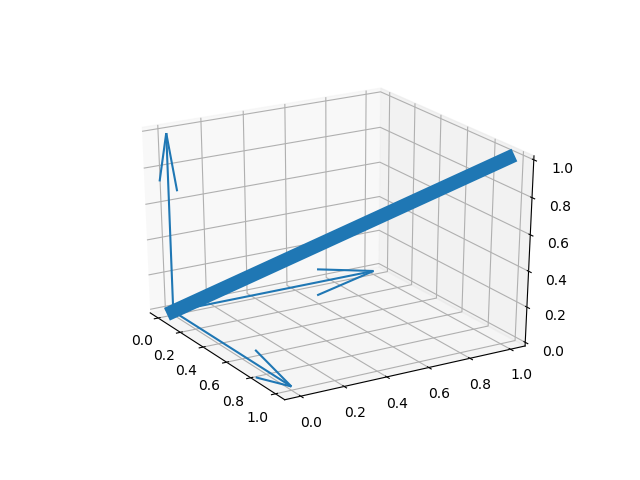

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot([0.0, 1.0], [0.0, 1.0], linewidth=10, zs=[0.0, 1.0])
fig.show()

In [8]:
def add_frame(axes):
    axes.quiver([0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0])
    

In [9]:
add_frame(ax)